## Dynamic Dijkstra's!
#### Parth Shisode
Many graphs representing real-world networks are often dynamic and ever-changing. For example, the flow of traffic on a street is rarely the same throughout the course of a day.

In this notebook I'll introduce a data-based spin on Dijkstra's algorithm, one of the key shortest-path algorithms, which can be applied in situations where a graph's edge weights change according to some pattern.

In [2807]:
import warnings
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from scipy.optimize import fsolve
import json
import heapq
import copy
from statsmodels.tsa.arima.model import ARIMA


from curve_fit import equation, fit_curve

In [2808]:
# This function will be used in a later cell, and is present here for transparency
def alter_data(df):
    altered_coeffs = np.array([
    47, 
    9e-03, 
    3e-02,  
    4e-03,
    -1e-05,  
    -3e-05])

    cond = (df['source'] == 0) & (df['dest'] == 1)
    timestamps = df[cond]['time']
    rates = equation(timestamps, altered_coeffs)
    df.loc[cond, 'edge_rates'] = rates


"Data is the new oil!" - Clive Humby

Data can be incredibly useful in allowing us to make predictions. From this point forward, we'll assume that we understand the properties of the graph we're working with. This includes knowing how many nodes are present and the directions of edges between these nodes.

In [2809]:
with open('metadata.json') as json_file:
    metadata = json.load(json_file)

metadata

{'num_nodes': 10,
 'adj_matrix_length': [[0, 54, 0, 0, 99, 64, 74, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 85, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 50],
  [52, 65, 0, 0, 51, 81, 69, 0, 0, 0],
  [89, 0, 62, 0, 0, 0, 0, 90, 0, 0],
  [59, 0, 95, 77, 0, 0, 0, 99, 82, 0],
  [92, 54, 78, 0, 0, 0, 0, 0, 90, 98],
  [0, 0, 0, 0, 67, 0, 0, 0, 0, 91],
  [0, 0, 90, 0, 0, 0, 55, 0, 0, 0],
  [0, 0, 97, 0, 0, 61, 0, 0, 0, 0]],
 'iterations': 5,
 'time_start': 0,
 'time_stop': 10,
 'num_points': 200}

The graph we'll be working with is a little different than usual. To simplify our example, each path has two elements aside from the two nodes that they connect. They are the edge length and the edge rate. The edge rate describes the speed at which an agent is able to cross an edge. The edge length describes the total distance required to cross from one node to another. This is represented by the adjacency matrix above, whose non-zero values describe edge lengths. We'll deal with edge rates later in this notebook!

We make an assumption here that edge rates and lengths are both positive.

Here's a visual of what our graph looks like!

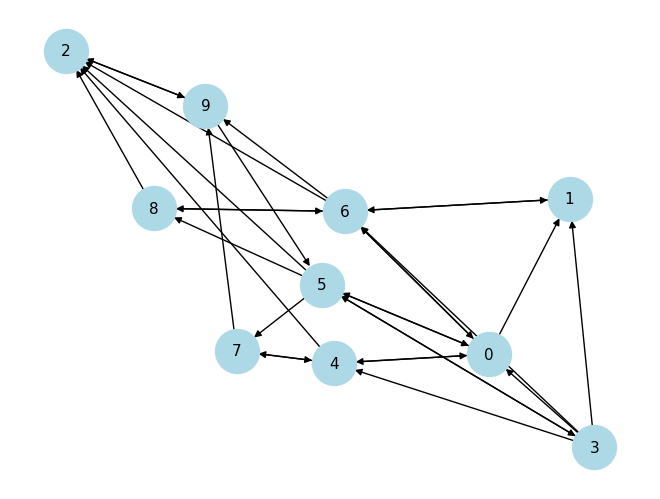

<Figure size 200x200 with 0 Axes>

In [2810]:
G = nx.from_numpy_array(np.array(metadata['adj_matrix_length']), create_using = nx.DiGraph())

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=1000, font_size=11)

# Display the graph
plt.figure(figsize=(2, 2))
plt.show()

We also happen to have access to non-random data relating edge weights to paths, and how these edge weights change over time. Our table looks something like this:

| Time | Source | Destination | Edge Rate |
|----------|----------|----------|----------|
| 12:07:00pm   |  Home  | Grocery Store | 10.7 MPH |
| 5:30:15pm    | Office   | Movie Theater  | 50.3 MPH |
| ...    | ...   | ...  | ... |

Of course, graphs are very general models and can represent many things besides just movement in the real world. The data we'll be using in this notebook going forward doesn't go by typical units to maintain the idea that graphs are abstract.

In [2811]:
data = pd.read_csv('data.csv')
real_time_data = data
data.sample(5).sort_values(by = 'time')

,time,source,dest,edge_rate
5,0.251256,0,1,70.147179
9856,2.814070,3,5,44.669395
16870,3.517588,5,3,56.918486
3288,4.422111,0,6,88.051761
2765,8.291457,0,5,122.950848


Edge rates of a graph changing over time can be likened in the real world to the average speed you'd be able to travel on a road changing throughout the course of the day. This would be due to factors such as traffic, car crashes, etc. Some of these things are predictable, while some are not. Meanwhile edge lengths, such as the length of a road, often never change.

In this next section, we'll be discussing how to use our data to generate a pattern for our edge rates. One way to generate predictions is by using our data to perform curve fitting! Specifically, we'll be fitting how edge rates can change with respect to time. Once we're able to predict how edge rates change, we can use this to define a shortest-path algorithm which uses this information we've gathered.

In [2812]:
num_nodes = metadata['num_nodes']

# Initializing a new adjacency matrix to fill with polynomials
adj_matrix_rate = [[0 for i in range(num_nodes)] for i in range(num_nodes)]
adj_matrix_coeffs = [[0 for i in range(num_nodes)] for i in range(num_nodes)]

for i in range(num_nodes**2):
    source = i // num_nodes
    dest = i % num_nodes

    if metadata['adj_matrix_length'][source][dest]:
        # Obtaining data relevant to the current path
        edge_data = data[(data['source'] == source) & (data['dest'] == dest)]
        
        # Fitting edge rates to time using a 5th degree polynomial using a pre-written 'fit_curve' function

        # Using the above coefficients to write a lambda function returning edge rates with respect to time t
        adj_matrix_coeffs[source][dest] = fit_curve(edge_data['time'], edge_data['edge_rate'], 5)
        
        
        # Not pertaining to this cell; used for the next demonstration
        if source == 0 and dest == 1:
            display_x = edge_data['time']
            display_y = edge_data['edge_rate']
            display_coeffs = fit_curve(edge_data['time'], edge_data['edge_rate'], 5)        

The below cell shows us the power of curve fitting! This demonstration pertains to a *single* edge and how its edge rate changes between time 0 and 10.

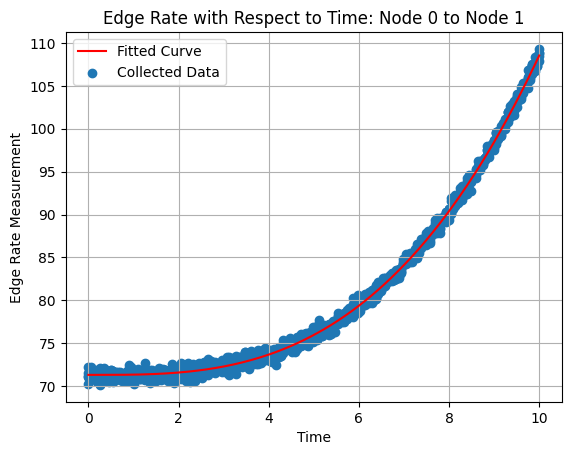

In [2813]:
x_points = np.linspace(metadata['time_start'], metadata['time_stop'], metadata['num_points'])
y_fit = equation(x_points, display_coeffs)
plt.plot(x_points, y_fit, color='red', label='Fitted Curve')
plt.scatter(display_x, display_y, label ='Collected Data')
plt.xlabel('Time')
plt.ylabel('Edge Rate Measurement')
plt.title('Edge Rate with Respect to Time: Node 0 to Node 1')
plt.legend()
plt.grid(True)
plt.show()


Dijkstra's algorithm normally works by starting at a source node, then exploring the next shortest node from the nodes that we've already accessed. This shortest-path algorithm is meant to be used with graphs whose edges never change. First, let's implement Dijkstra's algorithm with the projected edge rate values only at $t = 0$, and not consider how time elapses when we perform this algorithm.

If you don't understand every detail of the implementation, that's okay! For context, the data type of $metadata['adj\_matrix\_length']$ is a matrix holding the length for every edge in our graph. The purpose of the code snippet right below is meant to force the regular (static) version of Dijkstra's algorithm to take the edge rate value of a path at time t = 0.

In [2814]:
adj_matrix_rate_zero = copy.deepcopy(adj_matrix_coeffs)

for i in range(len(adj_matrix_rate)):
    for j in range(len(adj_matrix_rate[i])):
        if metadata['adj_matrix_length'][i][j] > 0:
            adj_matrix_rate_zero[i][j] = equation(0, adj_matrix_coeffs[i][j]) #adj_matrix_rate[i][j](0)

In [2815]:
def dijkstra_static(graph_mat, source):
    times = [np.inf for i in range(len(graph_mat))]
    shortest_paths = [[] for i in range(len(graph_mat))]
    times[source] = 0
    shortest_paths[source] = [source]

    # Heap queue has 2 elements: elapsed time, target node
    temp_q = [(0, source)]

    while temp_q: # Runs as long as there are still unvisited nodes
                # Pop node with smallest distance from priority queue
            current_time, current_node = heapq.heappop(temp_q)
            
            # Check if current distance is outdated
            if current_time > times[current_node]:
                continue

            # Explore neighbors of current node
            for i in range(len(graph_mat[current_node])):
                rate = adj_matrix_rate_zero[current_node][i]
                if rate:

                    # Use the edge_rate polynomial and edge_length value to determine
                    # how much time will be needed to cross the edge
                    """
                    def equation_to_solve(x):
                        result, _ = spi.quad(f, current_time, x)
                        return result - metadata['adj_matrix_length'][current_node][i]
                    
                    elapsed = fsolve(equation_to_solve, 1)
                    """
                    elapsed = metadata['adj_matrix_length'][current_node][i] / rate
                    

                    if elapsed > 0:
                        distance = current_time + elapsed
                        
                        # If new distance is shorter, update distances dictionary and priority queue
                        if distance < times[i]:
                            times[i] = distance
                            shortest_paths[i] = shortest_paths[current_node] + [i]  # Update shortest path
                            heapq.heappush(temp_q, (distance, i))

    return times, shortest_paths

In [2816]:
times, paths = dijkstra_static(adj_matrix_rate, 0)
for i in range(len(paths)):
    print("From node 0 to node " + str(i) + ": " + str(paths[i]))
print("\nTime from Source to Destination")
for i in range(len(paths)):
    print("Node 0 to node " + str(i) + ": " + str(times[i]))

From node 0 to node 0: [0]
From node 0 to node 1: [0, 1]
From node 0 to node 2: [0, 5, 2]
From node 0 to node 3: [0, 5, 3]
From node 0 to node 4: [0, 4]
From node 0 to node 5: [0, 5]
From node 0 to node 6: [0, 6]
From node 0 to node 7: [0, 5, 7]
From node 0 to node 8: [0, 5, 8]
From node 0 to node 9: [0, 5, 2, 9]

Time from Source to Destination
Node 0 to node 0: 0
Node 0 to node 1: 0.7571823536438264
Node 0 to node 2: 1.9573725040496626
Node 0 to node 3: 2.32347182420962
Node 0 to node 4: 1.2367786178281757
Node 0 to node 5: 0.8913511105433973
Node 0 to node 6: 0.8304514027749902
Node 0 to node 7: 2.7812126187042603
Node 0 to node 8: 2.152278489029063
Node 0 to node 9: 2.4582089608057105


Now, let's try implementing a version of Dijkstra's algorithm that utilizes information regarding how much time elapses after crossing each potential path. The algorithm now uses this information to update its knowledge of how edge rates change over time.

While the specific details of the implementation aren't important, the $adj\_matrix\_rate$ variable is a matrix of lambda functions. These functions returns the edge rate as a function of time.

In [2817]:
def dijkstra_dynamic(graph_mat, source):
    times = [np.inf for i in range(len(graph_mat))]
    shortest_paths = [[] for i in range(len(graph_mat))]
    times[source] = 0
    shortest_paths[source] = [source]

    # Heap queue has 2 elements: elapsed time, target node
    temp_q = [(0, source)]

    while temp_q: # Runs as long as there are still unvisited nodes
                # Pop node with smallest distance from priority queue
            current_time, current_node = heapq.heappop(temp_q)
            
            # Check if current distance is outdated
            if current_time > times[current_node]:
                continue

            # Explore neighbors of current node
            for i in range(len(graph_mat[current_node])):
                if metadata['adj_matrix_length'][current_node][i]:
                    coeffs = adj_matrix_coeffs[current_node][i]
                    f = lambda t: sum([coeffs[i] * t**i for i in range(len(coeffs))])
                    # Use the edge_rate polynomial and edge_length value to determine
                    # how much time will be needed to cross the edge
                    def equation_to_solve(x):
                        result, _ = spi.quad(f, current_time, x)
                        return result - metadata['adj_matrix_length'][current_node][i]
                    
                    elapsed = fsolve(equation_to_solve, 1)

                    if elapsed > 0:
                        distance = current_time + elapsed
                        
                        # If new distance is shorter, update distances dictionary and priority queue
                        if distance < times[i]:
                            times[i] = distance[0]
                            shortest_paths[i] = shortest_paths[current_node] + [i]  # Update shortest path
                            heapq.heappush(temp_q, (distance, i))

    return times, shortest_paths

Notice anything different regarding the outputs of the static and dynamic version of Dijkstra's algorithm?

That's right! The total time calculated to get from a source to a destination by the two algorithms are different. If you look closely at the shortest paths from node 0 to node 1 and node 0 to node 2, they're different between the two versions of this algorithm.

In [2818]:
times, paths = dijkstra_dynamic(adj_matrix_rate, 0)
print("Shortest Paths")
for i in range(len(paths)):
    print("Node 0 to node " + str(i) + ": " + str(paths[i]))
print("\nTime from Source to Destination")
for i in range(len(paths)):
    print("Node 0 to node " + str(i) + ": " + str(times[i]))

Shortest Paths
Node 0 to node 0: [0]
Node 0 to node 1: [0, 1]
Node 0 to node 2: [0, 5, 2]
Node 0 to node 3: [0, 5, 3]
Node 0 to node 4: [0, 4]
Node 0 to node 5: [0, 5]
Node 0 to node 6: [0, 6]
Node 0 to node 7: [0, 5, 7]
Node 0 to node 8: [0, 6, 8]
Node 0 to node 9: [0, 6, 9]

Time from Source to Destination
Node 0 to node 0: 0
Node 0 to node 1: 0.7571570870587738
Node 0 to node 2: 2.84951307543477
Node 0 to node 3: 3.2006987543745753
Node 0 to node 4: 1.2355143096647345
Node 0 to node 5: 0.8910557437049846
Node 0 to node 6: 0.8310243245592757
Node 0 to node 7: 3.656658348750324
Node 0 to node 8: 3.0202997867879366
Node 0 to node 9: 4.220361737691761


However, the real world doesn't always correspond to the data we've gathered! Unexpected external conditions might cause the real-time data to not look too similar to what we know. For example, what happens when the edge rate changes in an unpredictable way? How should we even classify whether an edge rate is changing differently than how we predicted?

We should start with creating some kind of a threshold which runs during our dynamic Dijkstra's algorithm; once the measured edge rates start differing too much from our fitted polynomial we should be alerted! Let's alter our data for the edge between node 0 and node 1 such that it doesn't reflect our fitted curve that we previously calculated.

All these next couple of code cells do is create some new data for us to analyze that are a little different from what we already have.

In [2819]:
# This function is only here for transparency, feel free to IGNORE
def new_data():
    altered_coeffs = np.array([
    71, 
    9e-03, 
    3e-02,  
    4e-03,
    -1.5e-05,  
    -2e-05])

    cond = (data['source'] == 0) & (data['dest'] == 1)
    timestamps = data[cond]['time']
    rates = equation(timestamps, altered_coeffs)
    real_time_data.loc[cond, 'edge_rate'] = rates
    
    return timestamps

In [2820]:
timestamps = new_data()

Now imagine we receive this data in real-time on top of the historical data we've collected. As we receive this data, we need a way to figure out whether our original polynomial is still a good way to predict edge rates. And so, in the background of our Dijkstra's algorithm, we should run a program which lets us know whether our real-time data is deviating too much.

In [2821]:
threshold = 2
passed = 0

adj_matrix_real = [[{'time' : np.array([]), 'predicted' : np.array([]), 'observed' : np.array([])} for i in range(num_nodes)] for i in range(num_nodes)]
crossed = False

def RMSE(d):
    return np.sum((d['predicted'] - d['observed']) ** 2) / d['predicted'].size

for t in timestamps:
    if crossed: 
        break
    for i in range(num_nodes**2):
        source = i // num_nodes
        dest = i % num_nodes
        if metadata['adj_matrix_length'][source][dest]:
            coeffs = adj_matrix_coeffs[source][dest]
            adj_matrix_real[source][dest]['predicted'] = np.append(adj_matrix_real[source][dest]['predicted'], equation(t, coeffs))

            rel_rates = real_time_data[(real_time_data['source'] == source) & (real_time_data['dest'] == dest)]

            adj_matrix_real[source][dest]['observed'] = np.append(adj_matrix_real[source][dest]['observed'], rel_rates[rel_rates['time'] == t]['edge_rate'].iloc[0])

            adj_matrix_real[source][dest]['time'] = np.append(adj_matrix_real[source][dest]['time'], t)
            
            if RMSE(adj_matrix_real[source][dest]) > threshold:
                print("Avg. RSME threshold crossed at time " + str(t) + " for edge between nodes " + str(source) + " and " + str(dest))
                passed = t
                crossed = True
                break

Avg. RSME threshold crossed at time 4.974874371859297 for edge between nodes 0 and 1


It seems that based on the average RSME threshold we set for the difference between our predicted and real-time observed edge rates, our polynomial stopped being an accurate predictor roughly at the above time. Now, let's graph our predicted and real-time data to see the difference!

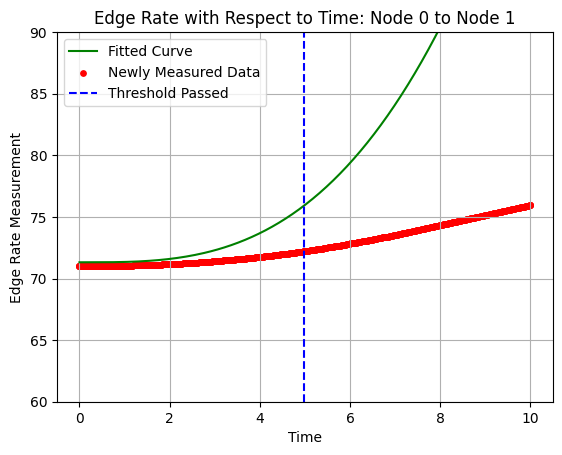

In [2822]:
rel_data = data[(data['source'] == 0) & (data['dest'] == 1)]

x_points = np.linspace(metadata['time_start'], metadata['time_stop'], metadata['num_points'])
altered_y_fit = equation(x_points, display_coeffs)
plt.plot(x_points, y_fit, color='green', label='Fitted Curve')
plt.scatter(rel_data['time'], rel_data['edge_rate'], color = 'red', label = 'Newly Measured Data', s = 15)
plt.xlabel('Time')
plt.ylabel('Edge Rate Measurement')
plt.title('Edge Rate with Respect to Time: Node 0 to Node 1')
plt.axvline(x = passed, color = 'blue', linestyle = '--', label = "Threshold Passed")
plt.legend()
plt.ylim(60, 90)
plt.grid(True)
plt.show()

Visually, we can immediately see that the polynomial curve is *not* reflective of new data that we've received.

If we've realized that our previously calculated polynomial is not a good enough predictor, we can enact an emergency technique! This would be an online technique, meaning that it would work with data as it's currently coming in. A candidate for a technique like this would be ARIMA. This stands for Autoregressive Integrated Moving Average. In short, it forecasts future values using past observations, utilizing autoregressive, differencing, and moving average techniques.

Of course, having an accurate polynomial which reflects your data is one of the most accurate ways to predict your data. However, if the historical data that we've used to predict our future data doesn't align with the situational real-time data, then the historical data is of no use. Given accurate data and unlimited resources, an online technique typically isn't a better choice compared to a trained ML model. However, in this scenario where real-time data is the only data we have, an online technique is the way to go!

In [2823]:
warnings.filterwarnings("ignore")

X = adj_matrix_real[0][1]['time']
y = adj_matrix_real[0][1]['observed']

X_done = x_points[:len(X)]
y_done = y_fit[:len(X)]
X_pred = x_points[len(X):]

model = ARIMA(y, order = (1, 3, 1))
y_pred = model.fit().forecast(len(X_pred))

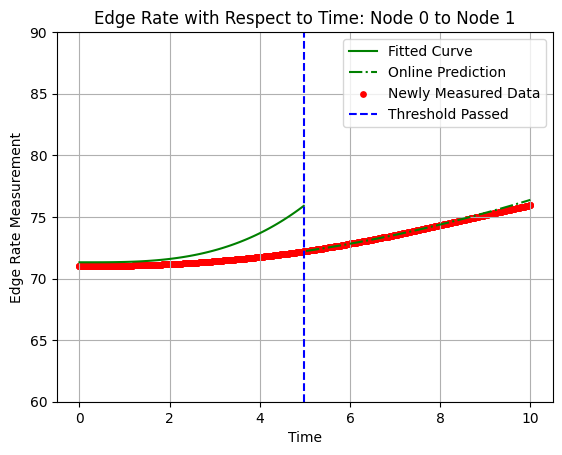

In [2824]:
plt.plot(X_done, y_done, color='green', label='Fitted Curve')
plt.plot(X_pred, y_pred, color='green', label='Online Prediction', linestyle = 'dashdot')
plt.scatter(rel_data['time'], rel_data['edge_rate'], color = 'red', label = 'Newly Measured Data', s = 15)
plt.xlabel('Time')
plt.ylabel('Edge Rate Measurement')
plt.title('Edge Rate with Respect to Time: Node 0 to Node 1')
plt.axvline(x = passed, color = 'blue', linestyle = '--', label = "Threshold Passed")
plt.legend()
plt.ylim(60, 90)
plt.grid(True)
plt.show()

The online prediction technique has got our model back on track to predicting the real-time data with less error!

So up to this point we've:
1. Used curve fitting to generate a polynomial model based on historical data of our edges over time
2. Determined how to detect whether our model is not reflecting our real-time data
3. Come up with a way to use only our real-time data

One way to make sure that we're not using a model that's not functioning properly is by re-running our dynamic Dijkstra's algorithm every time we reach a new node! Once we reach this new node we can see if the model has been accurately predicting our real-time data so far. If it hasn't been, we should stop and reconsider the model we're using to predict our data.

This will cause some overhead in computing resources, but if we're aiming for the true shortest path, this is certainly a way to acheive this.

```python
# Define our variables
threshold = ...
real-time data = []
predicted data = []
edge models = []


# Train the models for each edge
for each edge

    edge models[current edge] = curve_fit(historical data[current edge])


# Modify Dijkstra's algorithm to include the model's future predictions
def dynamic dijkstra(model)

    times, shortest paths = …
	heap queue = …

    while heap queue

        current time, current node = heap queue.pop()

        if time > times[node]

            continue

        for each neighbor

            time away = model.predict(time, source, neighbor)
            potential time = time + time away

            if potential_time < times[n]
            
                times[n] = potential time
                shortest paths[neighbor] = shortest paths[node] + i
                heap queue.push(potential time, n)

    return shortest paths


# As time goes on, evaluate how well our trained model is doing and change to online model if necessary
as time increases

    if agent arrived at a node

        next edge = dynamic dijkstra(model)[current node][upcoming edge]

        predicted edge weight = model.predict(current time, next edge)
        append(predicted data, predicted edge weight)

        observed edge weight = DATASTREAM.edge_weight(next edge)
        append(real-time data, observed edge weight)

        error = RMSE(predicted data, real-time data)

        if error > threshold
        
            model = ARIMA.fit(real-time data)     



The above pseudocode provides a structure for how, given historical data and a real-time data stream, a data-based approach to routing can be taken utilizing Dijkstra's algorithm. Please note that I've specified the use of curve fitting as a prediction technique given historical data and ARIMA as an online prediction technique; these two models do not have to be used specifically!

In [2825]:
def DATASTREAM(source, dest, time):
    return real_time_data[(real_time_data['source'] == source) & (real_time_data['dest'] == dest) & (real_time_data['time'] == time)]['edge_rate'].iloc[0]

def RMSE(arr1, arr2):
    return np.sum((arr1 - arr2) ** 2) / arr1.size

time_to_next = 0
source = 0
dest = 9
observed_data = np.array([])
predicted_data = np.array([])
path_taken = []

In [2826]:
def dijkstra_dynamic(graph_mat, source, curr_time, model_type = 'curve fit', datastream_data = None):
    times = [np.inf for i in range(len(graph_mat))]
    shortest_paths = [[] for i in range(len(graph_mat))]
    times[source] = curr_time
    shortest_paths[source] = [source]

    # Heap queue has 2 elements: elapsed time, target node
    temp_q = [(curr_time, source)]

    while temp_q: # Runs as long as there are still unvisited nodes
                # Pop node with smallest distance from priority queue
            current_time, current_node = heapq.heappop(temp_q)
            
            # Check if current distance is outdated
            if current_time > times[current_node]:
                continue

            # Explore neighbors of current node
            for i in range(len(graph_mat[current_node])):
                if metadata['adj_matrix_length'][current_node][i]:
                    if model_type == 'curve fit':
                        coeffs = adj_matrix_coeffs[current_node][i]
                        f = lambda t: sum([coeffs[i] * t**i for i in range(len(coeffs))])
                        # Use the edge_rate polynomial and edge_length value to determine
                        # how much time wll be needed to cross the edge
                        def equation_to_solve(x):
                            result, _ = spi.quad(f, current_time, x)
                            return result - metadata['adj_matrix_length'][current_node][i]
                        
                        elapsed = fsolve(equation_to_solve, 1)
                    
                    elif model_type == 'ARIMA':
                        X = x_points[len(datastream_data):]
                        y = datastream_data

                        X_done = x_points[:len(X)]
                        y_done = y_fit[:len(X)]
                        X_pred = x_points[len(X):]

                        model = ARIMA(y, order = (1, 3, 1))
                        y_pred = model.fit().forecast(len(X_pred))

                        elapsed = 0
                        traveled = 0

                        for t in range(len(X_pred)):
                            elapsed += x_points[1]

                            traveled += x_points[1] * y_pred[t]

                            if traveled >= metadata['adj_matrix_length'][current_node][i]:
                                break


                    if elapsed > 0:
                        distance = current_time + elapsed
                        
                        # If new distance is shorter, update distances dictionary and priority queue
                        if distance < times[i]:
                            times[i] = distance[0]
                            shortest_paths[i] = shortest_paths[current_node] + [i]  # Update shortest path
                            heapq.heappush(temp_q, (distance, i))

    return times, shortest_paths

In [2827]:
next_node = source
past_node = source
model_type = 'curve fit'

for t in x_points:
    times, shortest_paths = dijkstra_dynamic(metadata['adj_matrix_length'], past_node, time_to_next, model_type, observed_data)
    if len(shortest_paths[dest]) == 1:
        path_taken.append(next_node)
        break
    next_node = shortest_paths[dest][1]
    

    ind = np.argmin(np.abs(time_to_next - x_points))
    time_to_next = x_points[ind]


    real_edge_rate = DATASTREAM(past_node, next_node, time_to_next)

    observed_data = np.append(observed_data, real_edge_rate)

    if model_type == 'curve fit':
        coeffs = adj_matrix_coeffs[past_node][next_node]
        f = lambda n: sum([coeffs[i] * n**i for i in range(len(coeffs))])
        predicted_data = np.append(predicted_data, f(time_to_next))
        
        if RMSE(predicted_data, observed_data) > threshold:
            model_type = 'ARIMA'
            print('Switching to ARIMA')
        elif t % 1 == 0:
            print(RMSE(predicted_data, observed_data))
            print('Continuing with polynomial model')


    if t >= time_to_next:
        path_taken.append(past_node)
        past_node = next_node
        time_to_next = t + times[next_node]

path_taken

0.2441781101092643
Continuing with polynomial model


[0, 6, 9]

There we have it! Based on our pseudocode we've constructed a crude example of this data-based Dijkstra's algorithm! It may look a bit different for everyone while implemtning it as a result of the different data structures they choose to use.

<font size="+2">Please note that in order to truly implement this, we would need a real-time datastream, which I don't currently have access to. The purpose of this notebook was to create a framework and propose an idea in a progressive and simple way to someone who has a base-level understanding of algorithms and ML. I hope you enjoyed and got something out of this project! I'd like to thank my EE122 classmates and Professor Shyam Parekh. </font>